# SWB Computational Models

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import scipy.stats as stats
import pandas as pd
import scipy
from scipy.optimize import least_squares
import sklearn
from sklearn.metrics import r2_score
import random
import os
from statannot import add_stat_annotation
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
base_dir  = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
behav_dir = f'{base_dir}behavior_analysis/'


In [4]:
import sys
sys.path.append(f'{base_dir}swb_computational_modeling/swb_behav_models/scripts')
from SWB_modeling_utils import *

In [5]:
# load subj_ids of subj with preprocessed ephys data
subj_ids = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID.tolist()
# find subj without sufficient variation in mood ratings and drop from subj_ids list 
subj_ids = [subj_ids[idx] for idx in np.arange(0,len(subj_ids))[pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[2]).mood_var.isnull()]]
subj_ids


['MS002',
 'MS003',
 'MS009',
 'MS011',
 'MS015',
 'MS017',
 'MS019',
 'MS022',
 'MS024',
 'MS025',
 'MS026',
 'MS027',
 'MS029',
 'MS033',
 'MS035',
 'MS041',
 'MS043',
 'DA8',
 'DA023']

In [6]:
#get swb bdi and bai 
raw_dir = f'{base_dir}behavior_analysis/behavior_raw/'
subj_bdi = []
subj_bai = []
for subj_id in subj_ids:
    raw_data_dir = f'{raw_dir}{subj_id}/'
    raw_data_files = os.listdir(raw_data_dir)
    #load task data
    #load swb bdi and bai info to add to mood df
    raw_bdi_name = [x for x in raw_data_files if 'BDI' in x] #not all subj have BDI
    if raw_bdi_name:
        raw_bdi = pd.read_table(raw_data_dir+raw_bdi_name[0]) 
        bdi = raw_bdi['BDI Score'].iloc[-1]   
    else:
        bdi = 0
    subj_bdi.append(bdi)

    #bai loading (not all subj have BAI)
    raw_bai_name = [x for x in raw_data_files if 'BAI' in x]
    if raw_bai_name:
        raw_bai = pd.read_table(raw_data_dir+raw_bai_name[0]) 
        bai = raw_bai['BAI Score'].iloc[-1]   
    else:
        bai = 0
    subj_bai.append(bai)


In [7]:
list(zip(subj_ids,subj_bdi))

[('MS002', 14),
 ('MS003', 8),
 ('MS009', 16),
 ('MS011', 13),
 ('MS015', 26),
 ('MS017', 26),
 ('MS019', 12),
 ('MS022', 10),
 ('MS024', 16),
 ('MS025', 10),
 ('MS026', 9),
 ('MS027', 22),
 ('MS029', 32),
 ('MS033', 39),
 ('MS035', 15),
 ('MS041', 10),
 ('MS043', 23),
 ('DA8', 13),
 ('DA023', 14)]

In [8]:
all_mood = pd.concat([pd.read_csv(f'{behav_dir}behavior_preprocessed/{subj_id}_rate_data').assign(subj_id = subj_id) for subj_id in subj_ids]).reset_index()
all_mood = all_mood[all_mood.Round !=1]
all_mood['t1_round_idx'] = all_mood.Round-1
all_mood['t2_round_idx'] = all_mood.Round-2
all_mood['t3_round_idx'] = all_mood.Round-3
### recompute zscore using scipy function - edit clean behav function later!
all_norm_mood = []
for subj_id in subj_ids:
    all_norm_mood.extend(zscore(all_mood[all_mood.subj_id == subj_id].Rating))

all_mood['norm_mood'] = all_norm_mood
all_mood


,index,Round,Rating,RatingOnset,RT,zscore_mood,bdi,bai,subj_id,RatingOnset.1,t1_round_idx,t2_round_idx,t3_round_idx,norm_mood
2,2,4,70.0,539.343131,5.210698,0.320722,14,0,MS002,NaN,3,2,1,0.277664
3,3,7,70.0,572.673634,3.332630,0.320722,14,0,MS002,NaN,6,5,4,0.277664
4,4,10,69.0,605.109393,3.499831,0.185132,14,0,MS002,NaN,9,8,7,0.134538
5,5,13,71.0,638.791836,3.884104,0.456312,14,0,MS002,NaN,12,11,10,0.420789
6,6,16,71.0,671.977904,4.250371,0.456312,14,0,MS002,NaN,15,14,13,0.420789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,46,139,50.0,1808.030407,0.000618,-1.679568,14,0,DA023,NaN,138,137,136,-1.710160
972,47,142,65.0,1837.135575,3.097746,-0.579509,14,0,DA023,NaN,141,140,139,-0.562915
973,48,145,75.0,1872.784369,3.873045,0.153865,14,0,DA023,NaN,144,143,142,0.201915
974,49,148,50.0,1904.262850,0.000525,-1.679568,14,0,DA023,NaN,147,146,145,-1.710160


In [9]:
cols_to_nan = ['GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']

cols_to_zscore = cols_to_nan.copy()
cols_to_zscore.remove('GambleChoice')
cols_to_zscore.remove('Outcome')


In [10]:
# Load all subj behav data 
all_behav = pd.concat([pd.read_csv(f'{behav_dir}behavior_preprocessed/{subj_id}_task_data').assign(subj_id = subj_id) for subj_id in subj_ids]).reset_index(drop=True)
# NaN all data for regressor variables for no response trials
all_behav[cols_to_nan].iloc[(all_behav.GambleChoice!='gamble') & (all_behav.GambleChoice != 'safe')] = np.nan
# all_behav = all_behav[(all_behav.GambleChoice=='gamble') | (all_behav.GambleChoice == 'safe')].reset_index(drop=True)

# NaN all data for regressor variables for no outcome trials 
all_behav[cols_to_nan].iloc[(all_behav.Outcome!='good') & (all_behav.Outcome != 'bad')] = np.nan
# all_behav = all_behav[(all_behav.Outcome=='good') | (all_behav.Outcome == 'bad')].reset_index(drop=True)
# all_behav.Round = all_behav.Round.astype('Int64') # Round converts to float when nans are introduced to df 

all_behav[cols_to_zscore] = pd.DataFrame({f'{col}':zscore(all_behav[col]) for col in cols_to_zscore})

all_behav


,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE,subj_id
0,1,25.0,mix,513.380590,513.390239,515.450091,515.457173,2.059852,0.0,-1.10,...,-0.802918,-0.167804,-0.691616,-0.676564,-0.682435,0.631093,0.890652,-0.453244,0.501065,MS002
1,2,117.0,loss,522.640856,522.641563,524.596127,526.627092,1.954564,-0.3,-0.95,...,-0.902402,-0.730295,-0.882426,-0.676564,-0.682435,0.010697,-0.383415,-0.453244,-0.954618,MS002
2,3,79.0,gain,531.174799,531.175599,532.759061,534.780269,1.583462,0.4,0.00,...,1.497661,0.675933,0.667899,1.578898,1.773396,0.010697,0.641696,1.862125,0.501065,MS002
3,4,42.0,mix,545.592613,545.593355,548.084966,548.092333,2.491611,0.0,-0.80,...,0.900754,0.675933,0.667899,0.397465,0.852460,-0.860034,-1.115638,-0.453244,0.501065,MS002
4,5,85.0,gain,555.337336,555.345720,557.114656,559.135069,1.768936,0.5,0.00,...,0.826141,0.675933,0.667899,0.988181,0.737343,0.010697,0.788140,1.255719,0.501065,MS002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,146,74.0,gain,1887.903226,1887.904228,1889.144100,1891.160797,1.239872,0.4,0.00,...,0.515252,0.675933,0.667899,0.518294,0.257688,0.010697,0.641696,0.773350,0.501065,DA023
2848,147,88.0,gain,1895.726328,1895.727413,1896.891048,1898.907664,1.163636,0.5,0.00,...,1.522532,0.675933,0.667899,1.740002,1.811768,0.010697,0.788140,2.027508,0.501065,DA023
2849,148,144.0,loss,1905.271849,1905.272834,1907.119859,1907.126331,1.847025,-0.6,-1.33,...,0.813705,0.675933,0.667899,0.303488,0.718156,-1.436893,-1.891794,-0.453244,0.501065,DA023
2850,149,87.0,gain,1914.370711,1914.383463,1915.948606,1917.965770,1.565143,0.5,0.00,...,-0.715869,-1.662847,-0.524658,-0.676564,-0.682435,1.730390,0.788140,-0.453244,-1.919966,DA023


# Format Data Frame for GLM inputs 

In [11]:
vif_vars = ['Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE','decisionCPE']
# vif_vars = ['Profit', 'TotalProfit', 'GambleEV', 'RPE','decisionCPE']
# vif_vars = ['TotalProfit', 'GambleEV', 'RPE','decisionCPE']
# vif_vars = ['TotalProfit','RPE','decisionCPE']
# vif_vars = ['GambleEV','TotalProfit','RPE','decisionCPE']
# vif_vars = ['GambleEV','TotalProfit','decisionRegret','decisionRelief']
# vif_vars = ['GambleEV','TotalProfit','pRPE','nRPE']
# vif_vars = ['GambleEV','TotalProfit','decisionRegret','decisionRelief','nRPE','pRPE']
# vif_vars = ['Profit','TotalProfit','decisionCPE'] 
# vif_vars = ['GambleEV','TotalProfit','RPE','decisionCPE']
# vif_vars = ['choiceEV','CR','Profit', 'TotalProfit', 'decisionCPE']
# vif_vars = ['choiceEV','CR','TotalProfit','RPE','decisionCPE']
# vif_vars = ['choiceEV','CR','decisionCPE']
# vif_vars = ['GambleEV','decisionCPE']
# vif_vars = ['CR', 'choiceEV','RPE']
# vif_vars = ['GambleEV','RPE']
# vif_vars = ['choiceEV','CR','RPE','decisionCPE']
# vif_vars = ['GambleEV','RPE','decisionCPE']
# vif_vars = ['TotalProfit','CR', 'choiceEV','decisionCPE']
# vif_vars = ['TotalProfit','GambleEV','decisionCPE']
# vif_vars = ['TotalProfit','Profit','decisionCPE']
# vif_vars = ['TotalProfit','Profit','decisionCPE']
# vif_vars = ['choiceEV','CR','RPE','decisionCPE']
# vif_vars = ['GambleEV','RPE','decisionCPE']
test_vif = vif_scores(all_behav,vif_vars)
test_vif


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,feature,VIF
0,Profit,399.342984
1,TotalProfit,1.025656
2,CR,37.531085
3,choiceEV,124.649273
4,RPE,232.709565
5,decisionCPE,2.109811


In [13]:
# main_var = 'decisionCPE'
main_var = 'decisionRegret'
iter_vars = ['GambleEV','TotalProfit','Profit','RPE','decisionRelief']

var_combos = [[v,main_var] for v in iter_vars]

for i in range(1,len(iter_vars)-1):
    iter_list = [list(tup)+[main_var] for tup in list(itertools.combinations(iter_vars,i+1))]
    var_combos.extend(iter_list)
# var_combos

In [14]:
# # remove var combos that contain RPE and Profit because they are collinear 
var_combos = [combo for combo in var_combos if ('RPE' in combo and 'Profit' not in combo)|
              ('RPE' not in combo and 'Profit' in combo)|('RPE' not in combo and 'Profit' not in combo)]
# # remove var combos that contain GambleEV and Profit because they are collinear 
var_combos = [combo for combo in var_combos if ('GambleEV' in combo and 'Profit' not in combo)|
              ('GambleEV' not in combo and 'Profit' in combo)|('GambleEV' not in combo and 'Profit' not in combo)]
var_combos

[['GambleEV', 'decisionRegret'],
 ['TotalProfit', 'decisionRegret'],
 ['Profit', 'decisionRegret'],
 ['RPE', 'decisionRegret'],
 ['decisionRelief', 'decisionRegret'],
 ['GambleEV', 'TotalProfit', 'decisionRegret'],
 ['GambleEV', 'RPE', 'decisionRegret'],
 ['GambleEV', 'decisionRelief', 'decisionRegret'],
 ['TotalProfit', 'Profit', 'decisionRegret'],
 ['TotalProfit', 'RPE', 'decisionRegret'],
 ['TotalProfit', 'decisionRelief', 'decisionRegret'],
 ['Profit', 'decisionRelief', 'decisionRegret'],
 ['RPE', 'decisionRelief', 'decisionRegret'],
 ['GambleEV', 'TotalProfit', 'RPE', 'decisionRegret'],
 ['GambleEV', 'TotalProfit', 'decisionRelief', 'decisionRegret'],
 ['GambleEV', 'RPE', 'decisionRelief', 'decisionRegret'],
 ['TotalProfit', 'Profit', 'decisionRelief', 'decisionRegret'],
 ['TotalProfit', 'RPE', 'decisionRelief', 'decisionRegret'],
 ['GambleEV', 'TotalProfit', 'RPE', 'decisionRelief', 'decisionRegret']]

In [ ]:
[vif_scores(all_behav,test_vars).VIF.tolist() for test_vars in var_combos]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[[1.0028518241227422, 1.0028518241227404],
 [1.0090479708136895, 1.009047970813688],
 [1.2313648399135289, 1.2313648399135222],
 [1.3835130286584596, 1.3835130286584623],
 [1.262229807074776, 1.2622298070747735],
 [1.0033972352688825, 1.0095967517971152, 1.0121432560104449],
 [1.0045837832668747, 1.3859024026251554, 1.3897832191596804],
 [1.0136121630113208, 1.275773204167632, 1.273621553945943],
 [1.0146806481048727, 1.2382385277574748, 1.2348989342016],
 [1.0095975840666607, 1.3842666073962444, 1.3900244802561],
 [1.010315113500155, 1.2638148905543884, 1.2681640164370234],
 [1.594207864317411, 1.6341677298141546, 1.334766895883742],
 [1.8875261142726816, 1.7220594773706053, 1.4338448695111785],
 [1.0050867932086782,
  1.0101031044925979,
  1.386597487485519,
  1.396587101761667],
 [1.0140090210679156,
  1.010710680667878,
  1.2771808162683433,
  1.2798879886797756],
 [1.0138041827429545,
  1.8878836891629043,
  1.737865104106177,
  1.4440540319272541],
 [1.0146806705436877,
  1.60109

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Test Mood Models

In [16]:
model_inputs = {f'{("_").join(vars)}':{} for vars in var_combos}

for model_vars in var_combos:
    # var_key = ("_").join(model_vars)
    model_df = []
    for subj_id in subj_ids: 
        subj_dict = {}
        subj_mood_data = all_mood[all_mood.subj_id == subj_id]
        subj_norm_mood = subj_mood_data.norm_mood.tolist()
        subj_dict['mood'] = subj_norm_mood
        subj_behav_data = all_behav[all_behav.subj_id == subj_id]
        for reg in model_vars:
            # make reg name strings for model data keys
            reg_t1 = reg + '_t1'
            reg_t2 = reg + '_t2'
            reg_t3 = reg + '_t3'
            subj_dict[reg_t1] = [subj_behav_data[reg].iloc[np.where(subj_behav_data.Round==round_num)[0][0]] for round_num in subj_mood_data.t1_round_idx]
            subj_dict[reg_t2] = [subj_behav_data[reg].iloc[np.where(subj_behav_data.Round==round_num)[0][0]] for round_num in subj_mood_data.t2_round_idx]
            subj_dict[reg_t3] = [subj_behav_data[reg].iloc[np.where(subj_behav_data.Round==round_num)[0][0]] for round_num in subj_mood_data.t3_round_idx]

        subj_dict = pd.DataFrame(subj_dict).assign(subj_id = subj_id)
        model_df.append(subj_dict)
    
    model_inputs[("_").join(model_vars)] = pd.concat(model_df)

# [[all_behav[all_behav.subj_id==subj_id].decisionCPE.iloc[np.where(all_behav[all_behav.subj_id==subj_id].Round==round_num)[0 ][0]] for round_num in all_mood[all_mood.subj_id == subj_id].t2_round_idx] for subj_id in subj_ids]



In [17]:
model_results = {f'{model}':{f'{subj_id}':{} for subj_id in subj_ids} for model in model_inputs.keys()}
gamma_bounds = [(0.0001,1)]
n_inits = 2

for model in model_inputs.keys():
    model_data   = model_inputs[model]
    reg_list     = model.split('_')
    param_bounds = gamma_bounds + [(-10,10) for reg_num in range(len(reg_list)+1)]
    gam_inits    = np.array([np.random.uniform(0,1) for n in range(n_inits)])
    var_inits    = [np.random.uniform(-1,1,n_inits) for n in range(len(reg_list)+1)]

    for subj_id in subj_ids:
        subj_data      = model_inputs[model][model_inputs[model].subj_id == subj_id]
        var_init_grid  = itertools.product(*np.vstack((gam_inits,var_inits)))
        subj_model_fit = parallel_glm_fit(min_negll_glm,fit_swb_glm,var_init_grid,param_bounds,subj_data,reg_list)
        model_results[model][subj_id] = subj_model_fit





[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    3.0s remaining:    3.9s
[Parallel(n_jobs=-2)]: Done  11 out of  16 | elapsed:    3.3s remaining:    1.5s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    3.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  11 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done  11 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-2)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   7 out of  16 | elapsed:    0.2s remaining: 

In [18]:
bic_summary = []

for model in model_results.keys():
    model_df = {}
    res = model_results[model]
    mean_bic = np.mean([res[subj_id]['subj_dict']['bic'] for subj_id in subj_ids])
    model_df['model_id'] = model
    model_df['mean_bic'] = mean_bic
    for subj_id in subj_ids:
        model_df[subj_id] = res[subj_id]['subj_dict']['bic']
    bic_summary.append(pd.DataFrame(model_df,index=[0]))

    # pd.DataFrame({f'{subj_id}':res[subj_id]['subj_dict']['bic'] for subj_id in subj_ids})
bic_summary = pd.concat(bic_summary).reset_index(drop=True)
bic_summary

,model_id,mean_bic,MS002,MS003,MS009,MS011,MS015,MS017,MS019,MS022,...,MS025,MS026,MS027,MS029,MS033,MS035,MS041,MS043,DA8,DA023
0,GambleEV_decisionRegret,332.010715,332.762531,332.346366,339.841127,339.416228,338.260106,317.098794,337.613609,336.259218,...,326.784448,338.700839,341.691303,320.857928,335.367810,325.322980,328.989347,302.620061,335.475799,338.610891
1,TotalProfit_decisionRegret,330.001420,339.507967,333.583637,329.149688,339.272609,340.359568,322.489145,337.562148,324.032622,...,335.527956,320.390211,341.774747,307.769202,331.022232,325.139137,339.029944,314.103448,335.716313,337.285533
2,Profit_decisionRegret,329.497028,331.701339,333.240522,340.331621,337.047039,340.398968,314.663259,335.048117,332.435647,...,312.159184,335.071215,341.659074,329.464079,334.036202,319.556177,338.528183,275.269817,330.825020,339.929997
3,RPE_decisionRegret,331.557161,336.822295,333.657329,340.631380,335.980372,339.697034,319.775738,335.017771,333.731077,...,334.362291,332.759619,341.676499,334.344100,334.173637,317.621592,335.689991,290.492098,325.900376,341.242773
4,decisionRelief_decisionRegret,332.840133,339.381383,333.648736,338.945766,339.581936,339.913545,320.219088,334.437918,333.566526,...,336.244165,337.601338,341.434157,334.531049,334.748901,303.640853,338.865814,301.210293,335.433360,340.646676
5,GambleEV_TotalProfit_decisionRegret,376.076183,382.654810,381.937229,378.761745,389.016333,386.655160,366.978247,387.543841,369.870403,...,374.813556,370.373841,391.689200,342.353681,380.929870,375.111124,378.044402,352.599466,385.379044,384.449581
6,GambleEV_RPE_decisionRegret,377.536297,379.956451,382.341352,390.605401,385.477278,388.023200,364.855605,384.762857,383.707736,...,366.016261,382.498247,391.588611,369.231642,384.150284,366.009467,376.495137,327.883239,375.741548,388.584652
7,GambleEV_decisionRelief_decisionRegret,378.857738,381.420308,382.305140,388.643630,389.277419,387.566040,366.001985,384.436530,383.409131,...,370.192522,387.573267,391.376321,370.642602,384.694345,353.046708,377.146834,338.069923,384.822211,388.607163
8,TotalProfit_Profit_decisionRegret,373.205710,381.176347,382.976967,378.522282,386.685452,388.892991,364.658442,385.033134,363.982083,...,358.753679,370.141018,391.653561,345.895749,380.794797,369.158350,387.775901,324.900964,380.816825,384.687035
9,TotalProfit_RPE_decisionRegret,375.909150,385.520001,383.583400,379.110813,385.742491,388.499831,369.712277,384.954599,366.931545,...,380.575481,369.901749,391.666124,354.929054,380.597872,367.573066,385.390305,340.488891,375.886955,386.615640


In [20]:
bic_summary

,model_id,mean_bic,MS002,MS003,MS009,MS011,MS015,MS017,MS019,MS022,...,MS025,MS026,MS027,MS029,MS033,MS035,MS041,MS043,DA8,DA023
0,GambleEV_decisionRegret,332.010715,332.762531,332.346366,339.841127,339.416228,338.260106,317.098794,337.613609,336.259218,...,326.784448,338.700839,341.691303,320.857928,335.367810,325.322980,328.989347,302.620061,335.475799,338.610891
1,TotalProfit_decisionRegret,330.001420,339.507967,333.583637,329.149688,339.272609,340.359568,322.489145,337.562148,324.032622,...,335.527956,320.390211,341.774747,307.769202,331.022232,325.139137,339.029944,314.103448,335.716313,337.285533
2,Profit_decisionRegret,329.497028,331.701339,333.240522,340.331621,337.047039,340.398968,314.663259,335.048117,332.435647,...,312.159184,335.071215,341.659074,329.464079,334.036202,319.556177,338.528183,275.269817,330.825020,339.929997
3,RPE_decisionRegret,331.557161,336.822295,333.657329,340.631380,335.980372,339.697034,319.775738,335.017771,333.731077,...,334.362291,332.759619,341.676499,334.344100,334.173637,317.621592,335.689991,290.492098,325.900376,341.242773
4,decisionRelief_decisionRegret,332.840133,339.381383,333.648736,338.945766,339.581936,339.913545,320.219088,334.437918,333.566526,...,336.244165,337.601338,341.434157,334.531049,334.748901,303.640853,338.865814,301.210293,335.433360,340.646676
5,GambleEV_TotalProfit_decisionRegret,376.076183,382.654810,381.937229,378.761745,389.016333,386.655160,366.978247,387.543841,369.870403,...,374.813556,370.373841,391.689200,342.353681,380.929870,375.111124,378.044402,352.599466,385.379044,384.449581
6,GambleEV_RPE_decisionRegret,377.536297,379.956451,382.341352,390.605401,385.477278,388.023200,364.855605,384.762857,383.707736,...,366.016261,382.498247,391.588611,369.231642,384.150284,366.009467,376.495137,327.883239,375.741548,388.584652
7,GambleEV_decisionRelief_decisionRegret,378.857738,381.420308,382.305140,388.643630,389.277419,387.566040,366.001985,384.436530,383.409131,...,370.192522,387.573267,391.376321,370.642602,384.694345,353.046708,377.146834,338.069923,384.822211,388.607163
8,TotalProfit_Profit_decisionRegret,373.205710,381.176347,382.976967,378.522282,386.685452,388.892991,364.658442,385.033134,363.982083,...,358.753679,370.141018,391.653561,345.895749,380.794797,369.158350,387.775901,324.900964,380.816825,384.687035
9,TotalProfit_RPE_decisionRegret,375.909150,385.520001,383.583400,379.110813,385.742491,388.499831,369.712277,384.954599,366.931545,...,380.575481,369.901749,391.666124,354.929054,380.597872,367.573066,385.390305,340.488891,375.886955,386.615640


In [21]:
[(bic_summary.model_id[np.where(bic_summary.mean_bic == bic)[0][0]],bic) for bic in bic_list]


[('Profit_decisionRegret', 329.4970282879325),
 ('TotalProfit_decisionRegret', 330.00141984922476),
 ('RPE_decisionRegret', 331.5571614389317),
 ('GambleEV_decisionRegret', 332.01071460691736),
 ('decisionRelief_decisionRegret', 332.8401329042436),
 ('TotalProfit_Profit_decisionRegret', 373.20570967485145),
 ('TotalProfit_RPE_decisionRegret', 375.9091495061467),
 ('GambleEV_TotalProfit_decisionRegret', 376.07618307837754),
 ('TotalProfit_decisionRelief_decisionRegret', 377.0062981823135),
 ('Profit_decisionRelief_decisionRegret', 377.5203576494665),
 ('GambleEV_RPE_decisionRegret', 377.5362969526691),
 ('GambleEV_decisionRelief_decisionRegret', 378.85773839462036),
 ('RPE_decisionRelief_decisionRegret', 380.05109031571527),
 ('TotalProfit_Profit_decisionRelief_decisionRegret', 421.2205477181331),
 ('GambleEV_TotalProfit_RPE_decisionRegret', 421.9025070036936),
 ('GambleEV_TotalProfit_decisionRelief_decisionRegret', 423.07950455892404),
 ('TotalProfit_RPE_decisionRelief_decisionRegret',

In [22]:
ordered_model_ids = [bic_summary.model_id[np.where(bic_summary.mean_bic == bic)[0][0]] for bic in bic_list]
ordered_model_ids

['Profit_decisionRegret',
 'TotalProfit_decisionRegret',
 'RPE_decisionRegret',
 'GambleEV_decisionRegret',
 'decisionRelief_decisionRegret',
 'TotalProfit_Profit_decisionRegret',
 'TotalProfit_RPE_decisionRegret',
 'GambleEV_TotalProfit_decisionRegret',
 'TotalProfit_decisionRelief_decisionRegret',
 'Profit_decisionRelief_decisionRegret',
 'GambleEV_RPE_decisionRegret',
 'GambleEV_decisionRelief_decisionRegret',
 'RPE_decisionRelief_decisionRegret',
 'TotalProfit_Profit_decisionRelief_decisionRegret',
 'GambleEV_TotalProfit_RPE_decisionRegret',
 'GambleEV_TotalProfit_decisionRelief_decisionRegret',
 'TotalProfit_RPE_decisionRelief_decisionRegret',
 'GambleEV_RPE_decisionRelief_decisionRegret',
 'GambleEV_TotalProfit_RPE_decisionRelief_decisionRegret']

In [23]:
best_model_by_subj = [bic_summary.model_id[np.where(bic_summary[subj_id] == np.min(bic_summary[subj_id]))[0][0]] for subj_id in subj_ids]
subj_bdi_bic = list(zip(subj_ids,subj_bdi,best_model_by_subj))
subj_bdi_bic


[('MS002', 14, 'Profit_decisionRegret'),
 ('MS003', 8, 'GambleEV_decisionRegret'),
 ('MS009', 16, 'TotalProfit_decisionRegret'),
 ('MS011', 13, 'RPE_decisionRegret'),
 ('MS015', 26, 'GambleEV_decisionRegret'),
 ('MS017', 26, 'Profit_decisionRegret'),
 ('MS019', 12, 'decisionRelief_decisionRegret'),
 ('MS022', 10, 'TotalProfit_decisionRegret'),
 ('MS024', 16, 'TotalProfit_decisionRegret'),
 ('MS025', 10, 'Profit_decisionRegret'),
 ('MS026', 9, 'TotalProfit_decisionRegret'),
 ('MS027', 22, 'decisionRelief_decisionRegret'),
 ('MS029', 32, 'TotalProfit_decisionRegret'),
 ('MS033', 39, 'TotalProfit_decisionRegret'),
 ('MS035', 15, 'decisionRelief_decisionRegret'),
 ('MS041', 10, 'GambleEV_decisionRegret'),
 ('MS043', 23, 'Profit_decisionRegret'),
 ('DA8', 13, 'RPE_decisionRegret'),
 ('DA023', 14, 'TotalProfit_decisionRegret')]

In [24]:
highBDI_models = []
lowBDI_models = []
for tup in subj_bdi_bic:
    if tup[1] >= 20:
        highBDI_models.append(tup[2])
    else:
        lowBDI_models.append(tup[2])
    # subj_bdi_bic

In [25]:
# np.unique(highBDI_models)
highBDI_models


['GambleEV_decisionRegret',
 'Profit_decisionRegret',
 'decisionRelief_decisionRegret',
 'TotalProfit_decisionRegret',
 'TotalProfit_decisionRegret',
 'Profit_decisionRegret']

In [26]:
lowBDI_models

['Profit_decisionRegret',
 'GambleEV_decisionRegret',
 'TotalProfit_decisionRegret',
 'RPE_decisionRegret',
 'decisionRelief_decisionRegret',
 'TotalProfit_decisionRegret',
 'TotalProfit_decisionRegret',
 'Profit_decisionRegret',
 'TotalProfit_decisionRegret',
 'decisionRelief_decisionRegret',
 'GambleEV_decisionRegret',
 'RPE_decisionRegret',
 'TotalProfit_decisionRegret']

In [245]:
np.unique(lowBDI_models)

array(['GambleEV_RPE', 'GambleEV_decisionCPE', 'Profit_decisionCPE',
       'RPE_decisionCPE', 'TotalProfit_decisionCPE'], dtype='<U23')

In [ ]:
Profit_decisionRegret

In [28]:
model_param_dfs = {}

for mod in ordered_model_ids:
    best_dict = {}
    param_names = ['subj_id','gamma','beta0']
    param_names.extend(mod.split('_'))
    best_dict = {f'{param}':[] for param in param_names}
    for subj_id in subj_ids:
        subj_params = model_results[mod][subj_id]['subj_dict']['params']
        [best_dict[key].append(val) for key,val in list(zip(param_names[1:],subj_params))]
        best_dict['subj_id'].append(subj_id)
    model_param_dfs[mod] = pd.DataFrame(best_dict).assign(model_id=mod,bdi=subj_bdi)
    



In [29]:
model_param_dfs

{'Profit_decisionRegret':    subj_id     gamma     beta0    Profit  decisionRegret  \
 0    MS002  0.719192  0.011947  0.416648        0.026837   
 1    MS003  0.000100  0.006133  0.094203        0.366488   
 2    MS009  1.000000  0.006365  0.040861        0.070244   
 3    MS011  0.357255  0.006711  0.295155        0.052115   
 4    MS015  0.482174 -0.011092 -0.223335        0.199627   
 5    MS017  0.793657 -0.084237  0.257562        0.376224   
 6    MS019  0.334798  0.024676  0.252761        0.019812   
 7    MS022  0.129592 -0.014849  0.341392        0.071046   
 8    MS024  0.234288 -0.054354  0.334149        0.132099   
 9    MS025  0.913242  0.062926  0.750522        0.078865   
 10   MS026  0.422003 -0.008876  0.299740       -0.236875   
 11   MS027  0.446274 -0.001120 -0.052190        0.076510   
 12   MS029  0.956333  0.044674  0.181851        0.076933   
 13   MS033  0.313220 -0.014198  0.156133        0.267629   
 14   MS035  0.227186  0.056188  0.400540        0.355639   

In [46]:
sig_models = []
trend_models = []
sig_summary = []
trend_summary = []
for model_df in model_param_dfs.values():
    
    r,p = spearmanr(model_df.bdi,model_df.decisionRegret)
    
    if p < 0.05:
        sig_models.append(model_df.model_id.unique())
        sig_summary.append((model_df.model_id.unique().tolist(),r,p))
    if p < 0.1:
        trend_models.append(model_df.model_id.unique())
        trend_summary.append((model_df.model_id.unique().tolist(),r,p))

sig_summary


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[(['Profit_decisionRelief_decisionRegret'],
  0.48591850525696423,
  0.03491830333491491),
 (['GambleEV_TotalProfit_RPE_decisionRegret'],
  0.4595098908408249,
  0.04778386146349042),
 (['GambleEV_RPE_decisionRelief_decisionRegret'],
  0.6434899046065957,
  0.002952977517164622)]

In [35]:
sig_summary

[(['Profit_decisionRelief_decisionRegret'],
  0.48591850525696423,
  0.03491830333491491),
 (['GambleEV_TotalProfit_RPE_decisionRegret'],
  0.4595098908408249,
  0.04778386146349042),
 (['GambleEV_RPE_decisionRelief_decisionRegret'],
  0.6434899046065957,
  0.002952977517164622)]

In [33]:
trend_ids = [tm[0] for tm in trend_models]
trend_ids

['Profit_decisionRegret',
 'Profit_decisionRelief_decisionRegret',
 'TotalProfit_Profit_decisionRelief_decisionRegret',
 'GambleEV_TotalProfit_RPE_decisionRegret',
 'GambleEV_RPE_decisionRelief_decisionRegret']

In [34]:
t,p_t = ttest_ind(model_df.decisionRegret[model_df.bdi<20],model_df.decisionRegret[model_df.bdi>=20])
print(t,p_t)

-1.8921864297851603 0.07562447923351368


In [39]:
sig_models

[array(['Profit_decisionRelief_decisionRegret'], dtype=object),
 array(['GambleEV_TotalProfit_RPE_decisionRegret'], dtype=object),
 array(['GambleEV_RPE_decisionRelief_decisionRegret'], dtype=object)]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


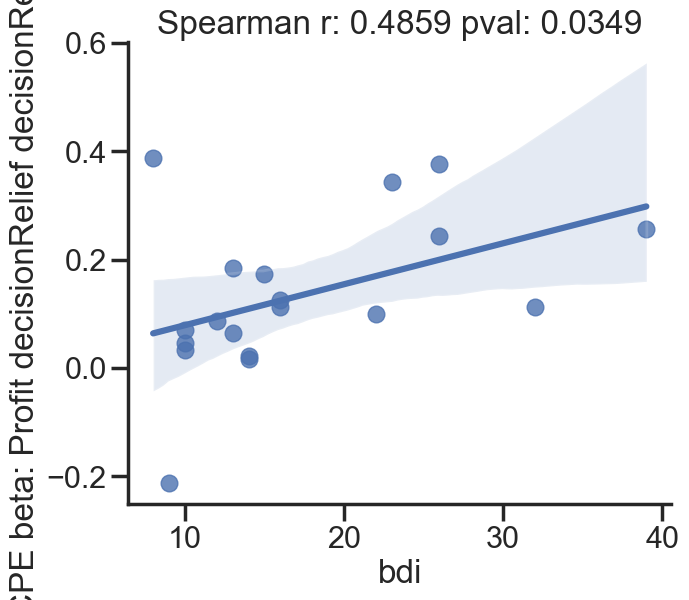

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


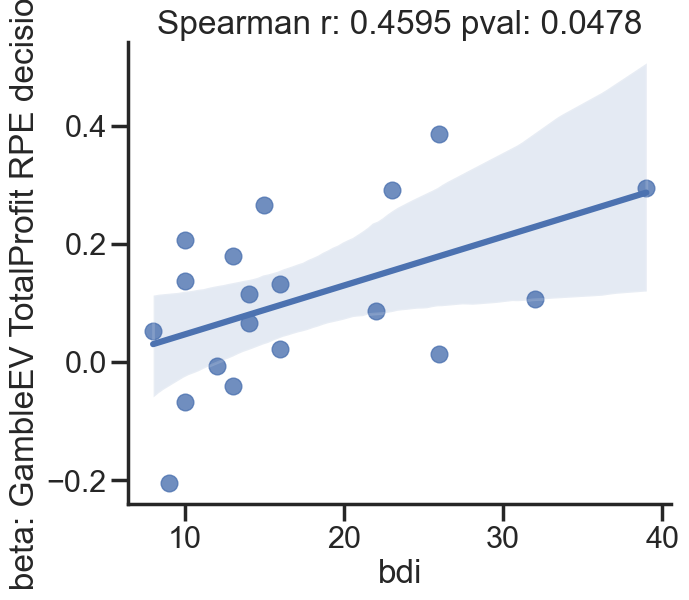

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


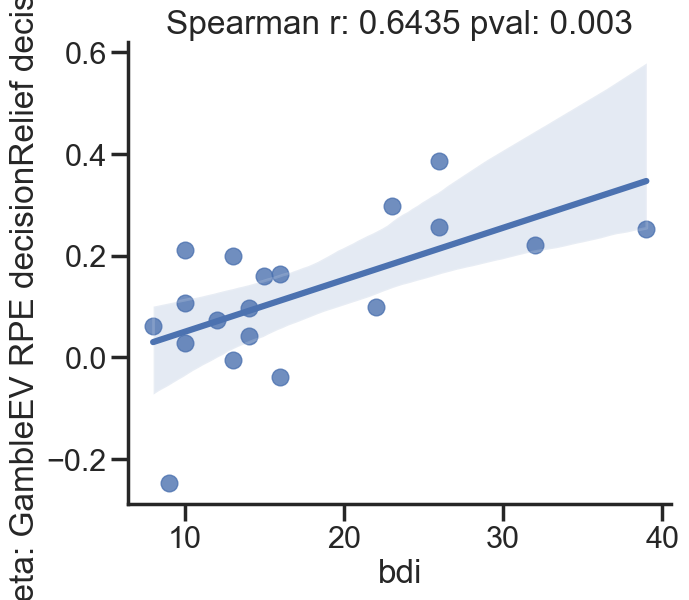

In [42]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

for model_id in sig_models:
    model_df = model_param_dfs[model_id[0]]
    
    # r,p = pearsonr(model_df.bdi,model_df.decisionCPE)
    r,p = spearmanr(model_df.bdi,model_df.decisionRegret)
    # t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
    # print(t,p_t)
    # fig = plt.scatter(model_df.bdi,model_df.decisionCPE)

    fig,ax = plt.subplots(figsize=(7,6))
    sns.regplot(data=model_df,x='bdi',y='decisionRegret',scatter=True)
    vars4title = model_df.model_id.unique()[0].split('_')
    plt.ylabel(f'CPE beta: {(" ").join(vars4title)}')
    plt.title(f'Spearman r: {np.round(r,4)} pval: {np.round(p,4)}')
    sns.despine()
    plt.show()


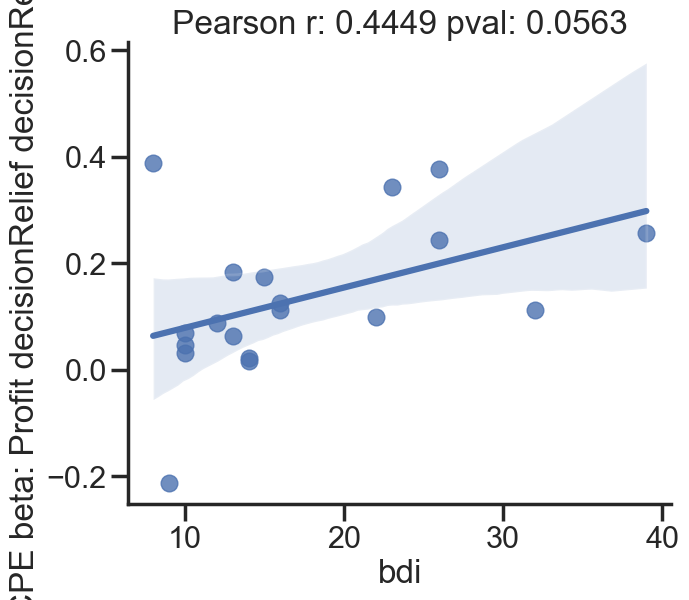

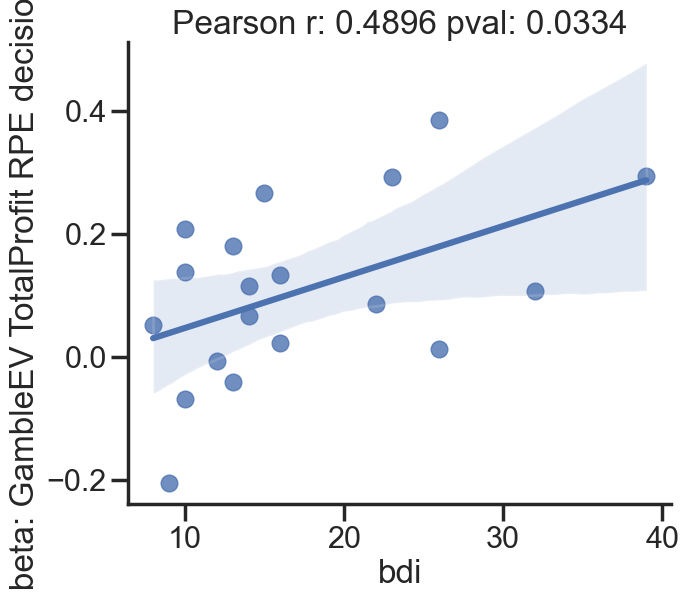

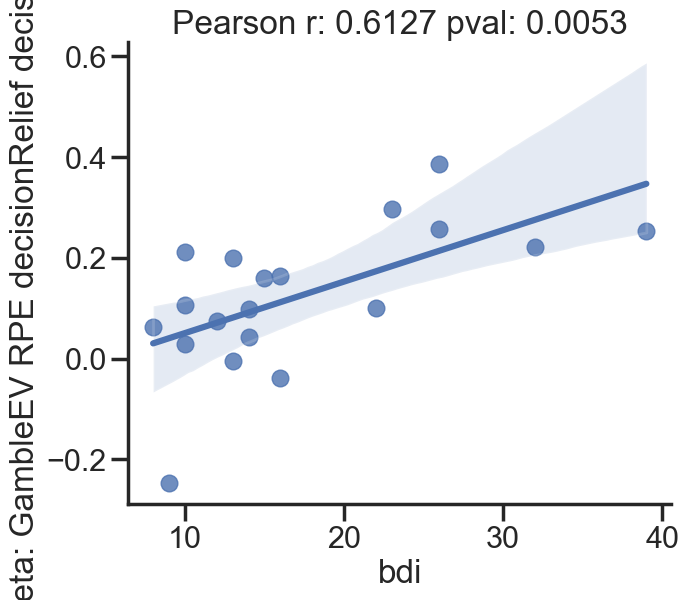

In [43]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

for model_id in sig_models:
    model_df = model_param_dfs[model_id[0]]
    
    # r,p = pearsonr(model_df.bdi,model_df.decisionCPE)
    r,p = pearsonr(model_df.bdi,model_df.decisionRegret)
    # t,p_t = ttest_ind(model_df.decisionCPE[model_df.bdi<20],model_df.decisionCPE[model_df.bdi>=20],equal_var=False)
    # print(t,p_t)
    # fig = plt.scatter(model_df.bdi,model_df.decisionCPE)

    fig,ax = plt.subplots(figsize=(7,6))
    sns.regplot(data=model_df,x='bdi',y='decisionRegret',scatter=True)
    vars4title = model_df.model_id.unique()[0].split('_')
    plt.ylabel(f'CPE beta: {(" ").join(vars4title)}')
    plt.title(f'Pearson r: {np.round(r,4)} pval: {np.round(p,4)}')
    sns.despine()
    plt.show()



# BEST MODEL

In [50]:
best_model = sig_models[-1][0]
best_model_df = model_param_dfs[best_model]
best_model_df

,subj_id,gamma,beta0,GambleEV,RPE,decisionRelief,decisionRegret,model_id,bdi
0,MS002,0.878942,0.001197,0.302152,0.163100,0.056171,0.097910,GambleEV_RPE_decisionRelief_decisionRegret,14
1,MS003,1.000000,0.000096,0.212765,0.119926,-0.070029,0.062707,GambleEV_RPE_decisionRelief_decisionRegret,8
2,MS009,0.000100,0.000183,-0.060712,0.217955,-0.396287,0.163696,GambleEV_RPE_decisionRelief_decisionRegret,16
3,MS011,0.657982,0.002262,0.060915,0.383664,-0.099663,-0.005263,GambleEV_RPE_decisionRelief_decisionRegret,13
4,MS015,0.054439,0.061564,-0.361802,-0.418577,0.792796,0.256731,GambleEV_RPE_decisionRelief_decisionRegret,26
5,MS017,0.802938,-0.037387,0.178366,0.120725,0.042093,0.386541,GambleEV_RPE_decisionRelief_decisionRegret,26
6,MS019,0.299342,0.009793,0.023348,0.098959,0.170881,0.073964,GambleEV_RPE_decisionRelief_decisionRegret,12
7,MS022,0.793107,-0.003932,-0.082171,0.117250,0.135103,0.029069,GambleEV_RPE_decisionRelief_decisionRegret,10
8,MS024,0.175755,-0.012322,-0.195153,0.575931,0.136550,-0.037543,GambleEV_RPE_decisionRelief_decisionRegret,16
9,MS025,0.892277,0.012868,0.375518,0.427930,0.118170,0.106369,GambleEV_RPE_decisionRelief_decisionRegret,10


In [51]:
depression_weights_plot = best_model_df.copy()
depression_weights_plot['Depression'] = ['Low BDI' if bdi<20 else 'High BDI' for bdi in depression_weights_plot.bdi]
depression_weights_plot

,subj_id,gamma,beta0,GambleEV,RPE,decisionRelief,decisionRegret,model_id,bdi,Depression
0,MS002,0.878942,0.001197,0.302152,0.163100,0.056171,0.097910,GambleEV_RPE_decisionRelief_decisionRegret,14,Low BDI
1,MS003,1.000000,0.000096,0.212765,0.119926,-0.070029,0.062707,GambleEV_RPE_decisionRelief_decisionRegret,8,Low BDI
2,MS009,0.000100,0.000183,-0.060712,0.217955,-0.396287,0.163696,GambleEV_RPE_decisionRelief_decisionRegret,16,Low BDI
3,MS011,0.657982,0.002262,0.060915,0.383664,-0.099663,-0.005263,GambleEV_RPE_decisionRelief_decisionRegret,13,Low BDI
4,MS015,0.054439,0.061564,-0.361802,-0.418577,0.792796,0.256731,GambleEV_RPE_decisionRelief_decisionRegret,26,High BDI
5,MS017,0.802938,-0.037387,0.178366,0.120725,0.042093,0.386541,GambleEV_RPE_decisionRelief_decisionRegret,26,High BDI
6,MS019,0.299342,0.009793,0.023348,0.098959,0.170881,0.073964,GambleEV_RPE_decisionRelief_decisionRegret,12,Low BDI
7,MS022,0.793107,-0.003932,-0.082171,0.117250,0.135103,0.029069,GambleEV_RPE_decisionRelief_decisionRegret,10,Low BDI
8,MS024,0.175755,-0.012322,-0.195153,0.575931,0.136550,-0.037543,GambleEV_RPE_decisionRelief_decisionRegret,16,Low BDI
9,MS025,0.892277,0.012868,0.375518,0.427930,0.118170,0.106369,GambleEV_RPE_decisionRelief_decisionRegret,10,Low BDI


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'Regret Spearman R:0.643 P:0.003')

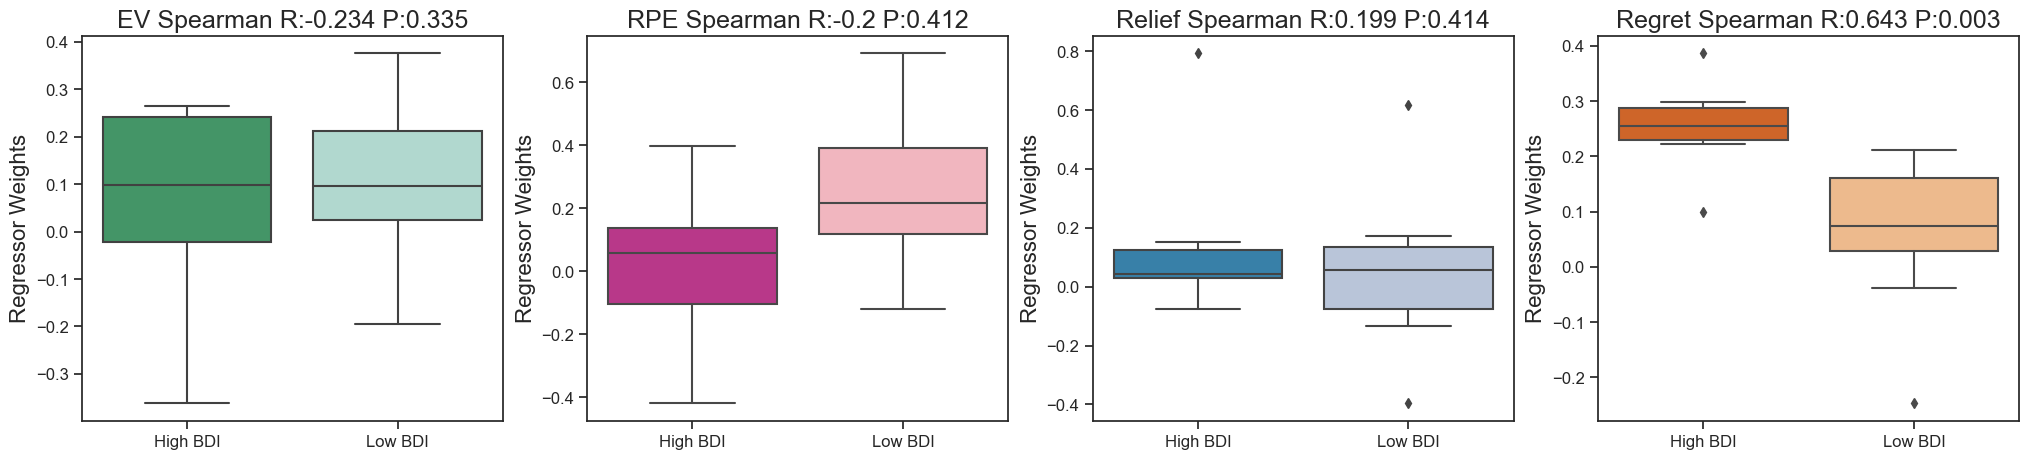

In [60]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,5))
sns.set_theme(style='ticks',font='Arial') 
sns.boxplot(ax=ax1,data=depression_weights_plot, x='Depression',y='GambleEV',order=["High BDI", "Low BDI"],palette='BuGn_r')
sns.boxplot(ax=ax2,data=depression_weights_plot, x='Depression',y='RPE',order=["High BDI", "Low BDI"],palette='RdPu_r')
sns.boxplot(ax=ax3,data=depression_weights_plot, x='Depression',y='decisionRelief',order=["High BDI", "Low BDI"],palette='PuBu_r')
sns.boxplot(ax=ax4,data=depression_weights_plot, x='Depression',y='decisionRegret',order=["High BDI", "Low BDI"],palette='Oranges_r')

#ax1.set_ylim(-0.2,0.2)
ax1.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
r1,p1= spearmanr(depression_weights_plot.bdi,depression_weights_plot.GambleEV)
ax1.set_title(f'EV Spearman R:{np.round(r1,3)} P:{np.round(p1,3)}',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax2.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
r2,p2= spearmanr(depression_weights_plot.bdi,depression_weights_plot.RPE)
ax2.set_title( f'RPE Spearman R:{np.round(r2,3)} P:{np.round(p2,3)}',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax3.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
r3,p3= spearmanr(depression_weights_plot.bdi,depression_weights_plot.decisionRelief)
ax3.set_title(f'Relief Spearman R:{np.round(r3,3)} P:{np.round(p3,3)}',weight='medium',fontsize=18)

#ax2.set_ylim(-0.1,0.6)
ax4.set_ylabel('Regressor Weights',x=0.02,weight='medium',fontsize=16)
ax4.set_xlabel(None)
ax4.tick_params(labelsize=12)
r4,p4= spearmanr(depression_weights_plot.bdi,depression_weights_plot.decisionRegret)
ax4.set_title(f'Regret Spearman R:{np.round(r4,3)} P:{np.round(p4,3)}',weight='medium',fontsize=18)


